> This is a rework of my task during Machine Learning class in 2022.

> Goal(s):
- to construct a model using the Gradient Descent based Linear Regression approach (scratch) to predict insurance prices (a column named "charges" in the dataset) based on the given dataset.

> Requirement(s):
- use all available variables.
- the dataset should be cleaned of missing values with rules as follows: numerical variables replaced with its column average and categorical variables replaced with its column modes. these rules are applied based on column named "sex".
- the implementation process should include exploratory data analysis of every independent variables and visualization of correlations between every independent variables with dependent variable.
- set up training and testing dataset with proportion 4:1.
- do evaluation with MAE, MSE, RMSE, and $R^2$

> References **[A]**:
1.  https://www.scribbr.com/statistics/correlation-coefficient/
2.  https://www.statology.org/multicollinearity-regression/
3.  https://online.stat.psu.edu/stat462/node/180/
4.  https://statisticsbyjim.com/regression/interpret-r-squared-regression/
5.  https://www.simplypsychology.org/p-value.html
6.  https://www.statology.org/anova-f-value-p-value/
7.  https://www.statology.org/dummy-variable-trap/

> References **[B]**:
*  Class/University notes
*  https://medium.com/@pritioli/implementing-linear-regression-from-scratch-747343634494
*  https://marnec.github.io/ML/ML3/

# Import Essentials

## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Dataset

In [2]:
data = pd.read_csv('../dataset/insurance-cost.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
def split_dataset(x, y, size, state=np.random.randint(0, 100)):
  data_A_X, data_B_X, data_A_Y, data_B_Y = train_test_split(x, y, train_size = size, random_state = state)
  data_A = pd.concat([data_A_X, data_A_Y], axis=1)
  data_B = pd.concat([data_B_X, data_B_Y], axis=1)
  return data_A, data_B

In [4]:
data_train, data_test = split_dataset(data.drop(columns='charges'), data['charges'], 0.8, 21)

> Dividing the raw data into training and testing sets using a 4:1 ratio.

# Dataset Overview

In [5]:
data_train.head()

,age,sex,bmi,children,smoker,region,charges
1225,33,female,39.82,1,no,southeast,4795.6568
209,40,male,41.23,1,no,northeast,6610.1097
1309,41,male,32.20,2,no,southwest,6875.9610
1075,32,female,29.59,1,no,southeast,4562.8421
711,50,female,23.54,2,no,southeast,10107.2206


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1070 entries, 1225 to 969
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   sex       1070 non-null   object 
 2   bmi       1068 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1068 non-null   object 
 5   region    1070 non-null   object 
 6   charges   1070 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 66.9+ KB


> This training dataset consists of both independent (all numerical) and dependent variables of unequal length with some null values. Therefore, we need to proceed to the Handling Missing Value step.

In [7]:
data_train.describe()

,age,bmi,children,charges
count,1070.000000,1068.000000,1070.000000,1070.000000
mean,38.887850,30.651372,1.067290,13060.472727
std,14.098429,6.030866,1.181853,12181.643813
min,18.000000,16.815000,0.000000,1121.873900
25%,26.000000,26.315000,0.000000,4520.915425
50%,39.000000,30.495000,1.000000,8973.257550
75%,51.000000,34.580000,2.000000,16132.897662
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
numvar_col = ['age', 'bmi', 'children']
ctgvar_col = ['sex', 'smoker', 'region']

In [9]:
for i in ctgvar_col:
  print(data_train[i].value_counts())
  print()

sex
male      545
female    525
Name: count, dtype: int64

smoker
no     854
yes    214
Name: count, dtype: int64

region
southeast    295
southwest    268
northwest    260
northeast    247
Name: count, dtype: int64



> The categorical columns in the training dataset are well-formatted with no typos or unusual values.

# Handling Missing/Error Value

## Missing Value on "bmi"

> Since "bmi" is a numerical variable, then all missing values will be replaced by this variable average, based on gender.

In [10]:
data_gender = data_train.groupby('sex')['bmi'].mean()
print(f"Male: {data_gender['male'].mean()}")
print(f"Female: {data_gender['female'].mean()}")

Male: 31.053474264705883
Female: 30.23392175572519


In [11]:
data_train[data_train['bmi'].isnull()]

,age,sex,bmi,children,smoker,region,charges
51,21,female,NaN,2,no,northwest,3579.8287
30,22,male,NaN,0,yes,southwest,35585.5760


In [12]:
data_train.loc[data_train['sex'] == 'male', 'bmi'] = data_train.loc[data_train['sex'] == 'male', 'bmi'].fillna(data_gender['male'])
data_train.loc[data_train['sex'] == 'female', 'bmi'] = data_train.loc[data_train['sex'] == 'female', 'bmi'].fillna(data_gender['female'])

In [13]:
data_train['bmi'].isnull().sum()

0

> Hence, there is no more missing value found on this variable.

## Missing Value on "smoker"

> Since "smoker" is a categorical variable, then all missing values will be replaced by this variable average, based on gender.

In [14]:
data_smoker = data_train.groupby('sex')['smoker'].agg(pd.Series.mode)
print(f"Male: {data_smoker['male']}")
print(f"Female: {data_smoker['female']}")

Male: no
Female: no


In [15]:
data_train[data_train['smoker'].isnull()]

,age,sex,bmi,children,smoker,region,charges
32,19,female,28.60,5,NaN,southwest,4687.7970
53,36,male,34.43,0,NaN,southeast,37742.5757


In [16]:
data_train.loc[data_train['sex'] == 'male', 'smoker'] = data_train.loc[data_train['sex'] == 'male', 'smoker'].fillna(data_smoker['male'])
data_train.loc[data_train['sex'] == 'female', 'smoker'] = data_train.loc[data_train['sex'] == 'female', 'smoker'].fillna(data_smoker['female'])

In [17]:
data_train['smoker'].isnull().sum()

0

> Hence, there is no more missing value found on this variable.

# Exploratory Data Analysis (EDA)

In [18]:
def visualize_numvar(df, col_names, col_target, type):
  data = df[col_names]
  rows = np.ceil((len(data.columns)) / 2).astype(int)
  fig, axs = plt.subplots(rows, 2, figsize=(10, 10))
  axs = axs.flatten()
  for idx, col_name in enumerate(col_names):
    if(type == 'dist'):
      sns.histplot(data[col_name], ax=axs[idx], kde=True)
      axs[idx].set_title(f"Distribution Plot ({col_name})")
    elif(type == 'box'):
      sns.boxplot(x=df[col_target], ax=axs[idx])
      axs[idx].set_title(f"Box Plot ({col_name})")
    elif(type == 'scatter'):
      sns.scatterplot(x=df[col_target], y=data[col_name], ax=axs[idx])
      axs[idx].set_title(f"Scatter Plot ({col_name})")
  plt.tight_layout()
  plt.show()

In [19]:
def visualize_ctgvar(df, col_names, col_target, type):
  data = df[col_names]
  rows = np.ceil((len(data.columns)) / 2).astype(int)
  fig, axs = plt.subplots(rows, 2, figsize=(6, 3))
  axs = axs.flatten()
  for idx, col_name in enumerate(col_names):
    if(type == 'dist'):
      sns.histplot(data[col_name], ax=axs[idx], kde=True)
      axs[idx].set_title(f"Distribution Plot ({col_name})")
    elif(type == 'box'):
      sns.boxplot(x=df[col_target], y=data[col_name], ax=axs[idx])
      axs[idx].set_title(f"Box Plot ({col_name})")
  plt.tight_layout()
  plt.show()

## Distribution Plot

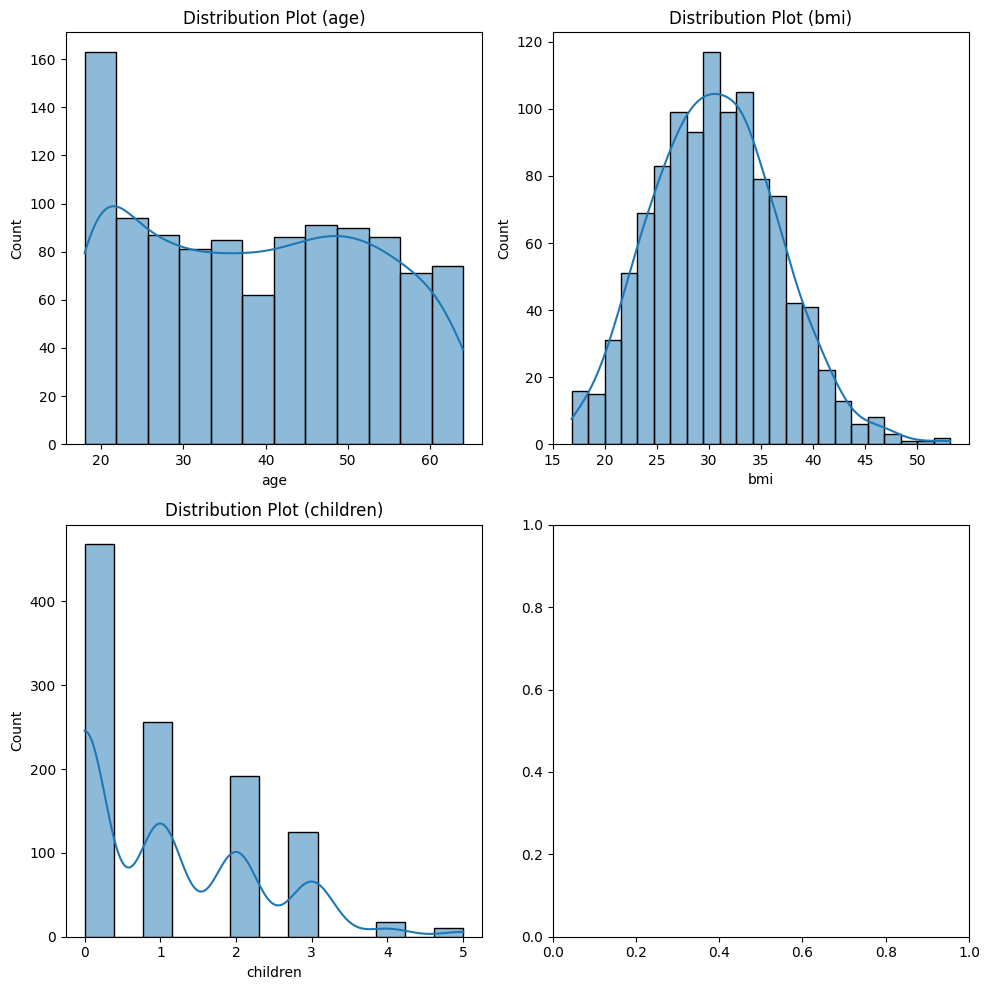

In [20]:
visualize_numvar(data_train, numvar_col, 'charges', 'dist')

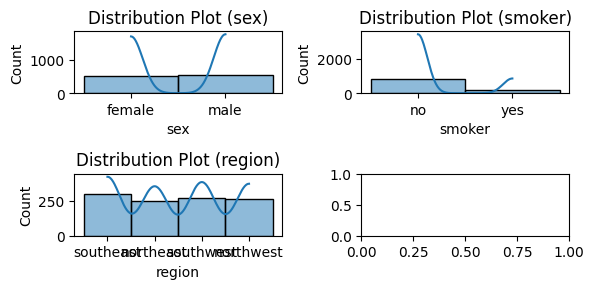

In [21]:
visualize_ctgvar(data_train, ctgvar_col, 'Profit', 'dist')

> The distribution of the variables in the dataset appears to be relatively imbalanced for 'smoker' and relatively balanced for the rest.

## Box Plot

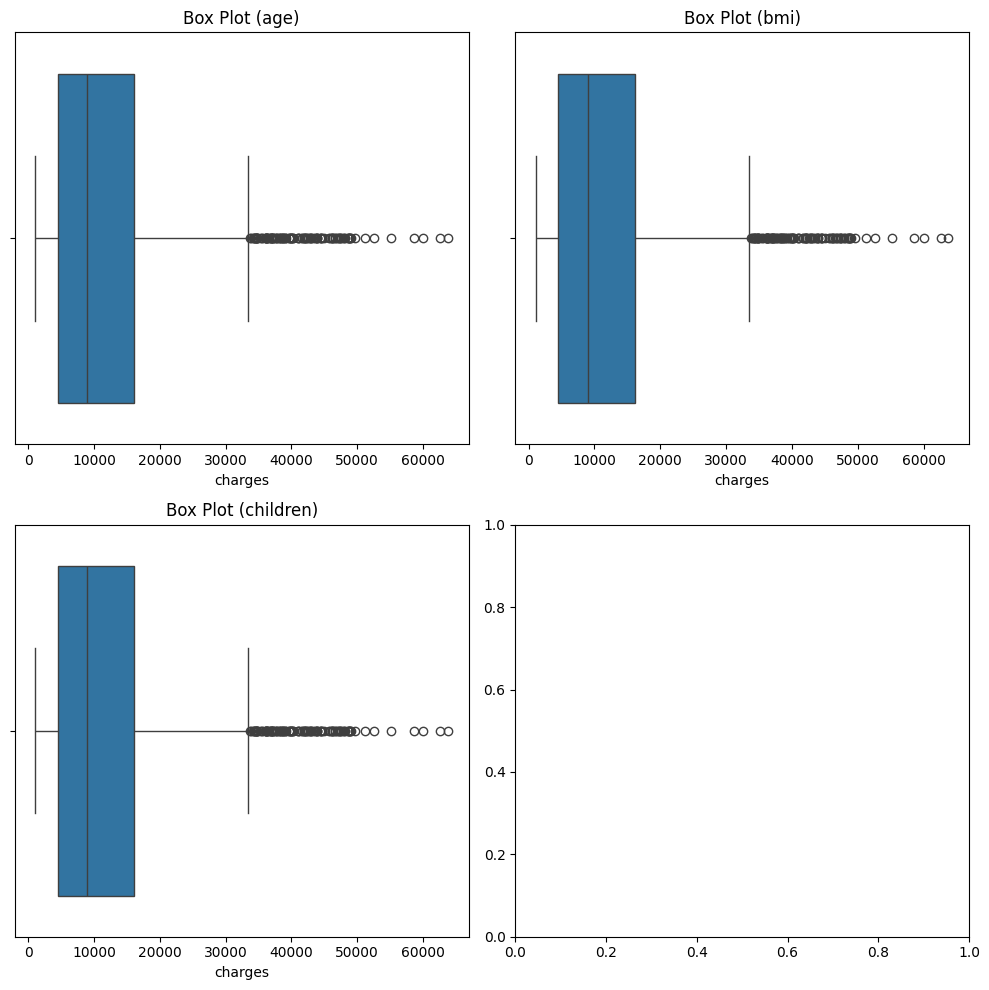

In [22]:
visualize_numvar(data_train, numvar_col, 'charges', 'box')

> Based on the graph above, it seems that there are outliers on most of variables in this dataset.

In [23]:
data_train = data_train[data_train['charges'] < 24000]

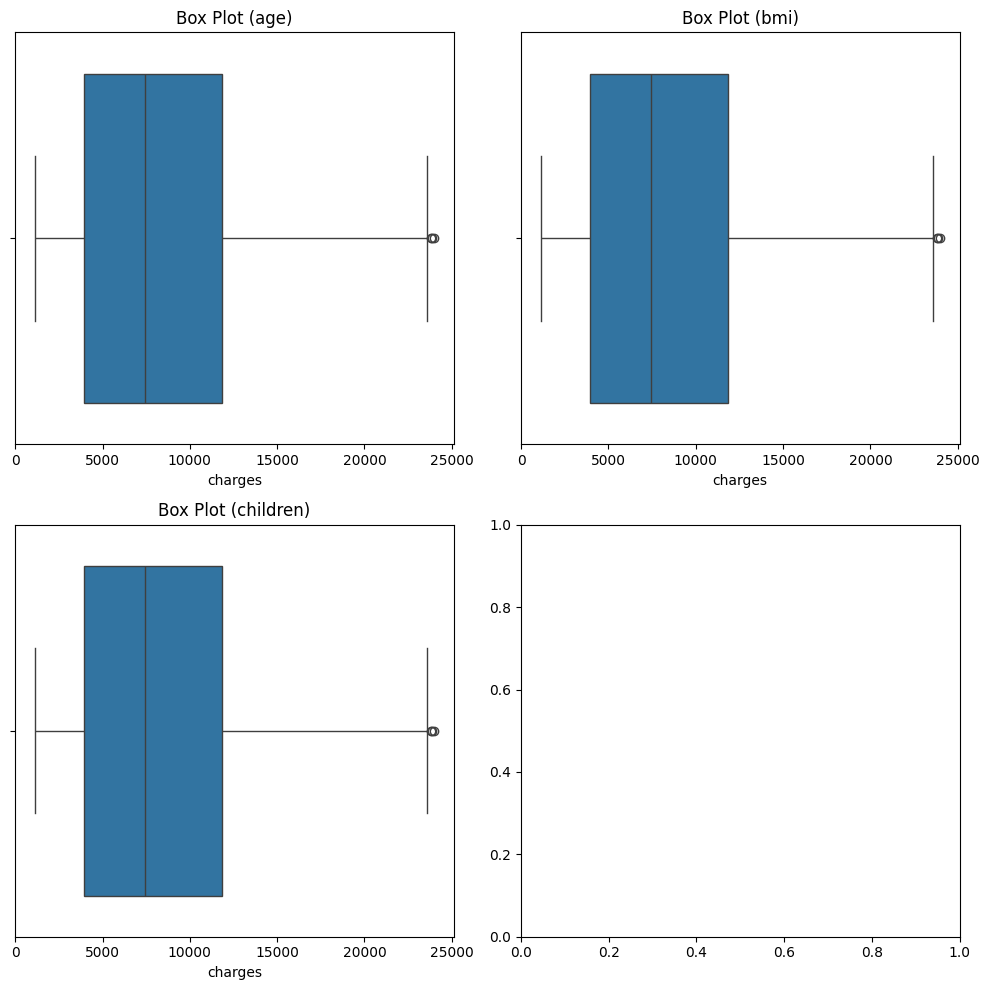

In [24]:
visualize_numvar(data_train, numvar_col, 'charges', 'box')

> Based on the graph above, it seems that there is much fewer outliers on most of variables in this dataset.

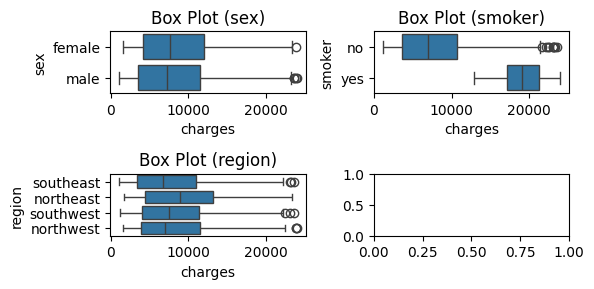

In [25]:
visualize_ctgvar(data_train, ctgvar_col, 'charges', 'box')

## Scatter Plot

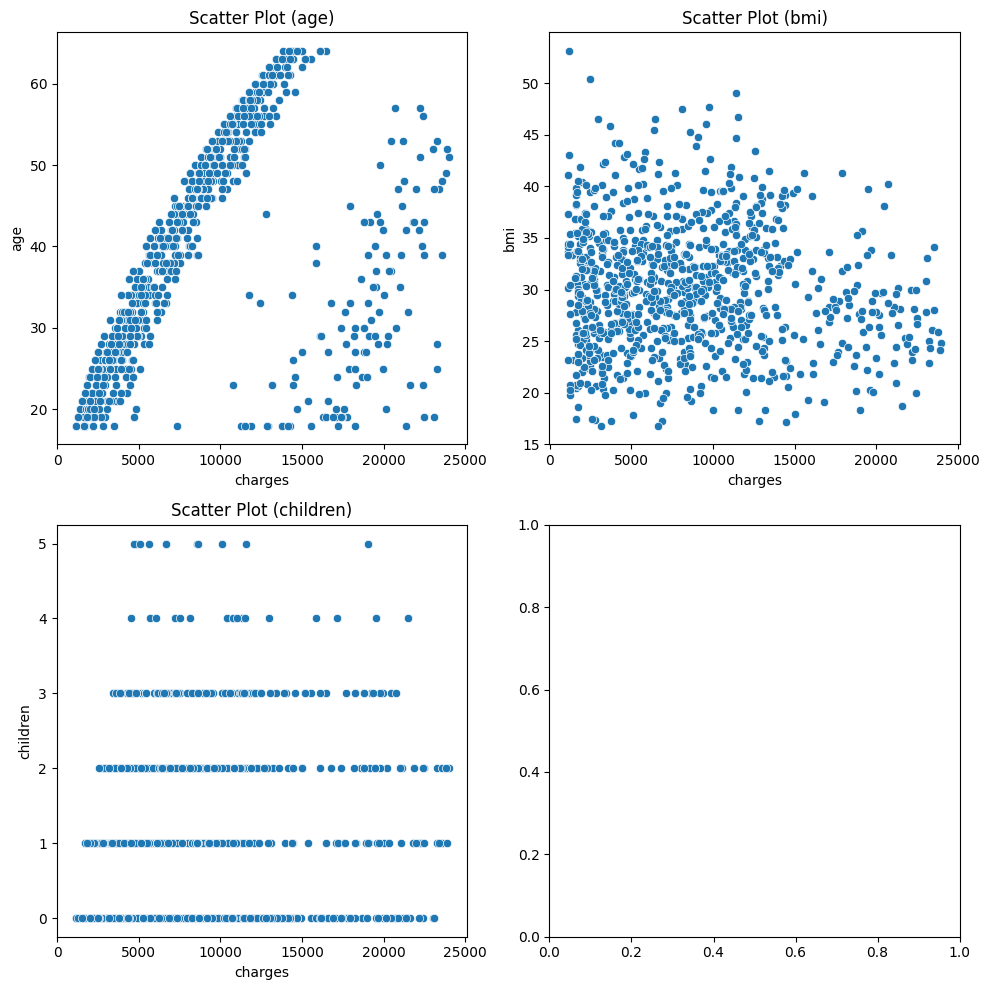

In [26]:
visualize_numvar(data_train, numvar_col, 'charges', 'scatter')

## Correlation Analysis

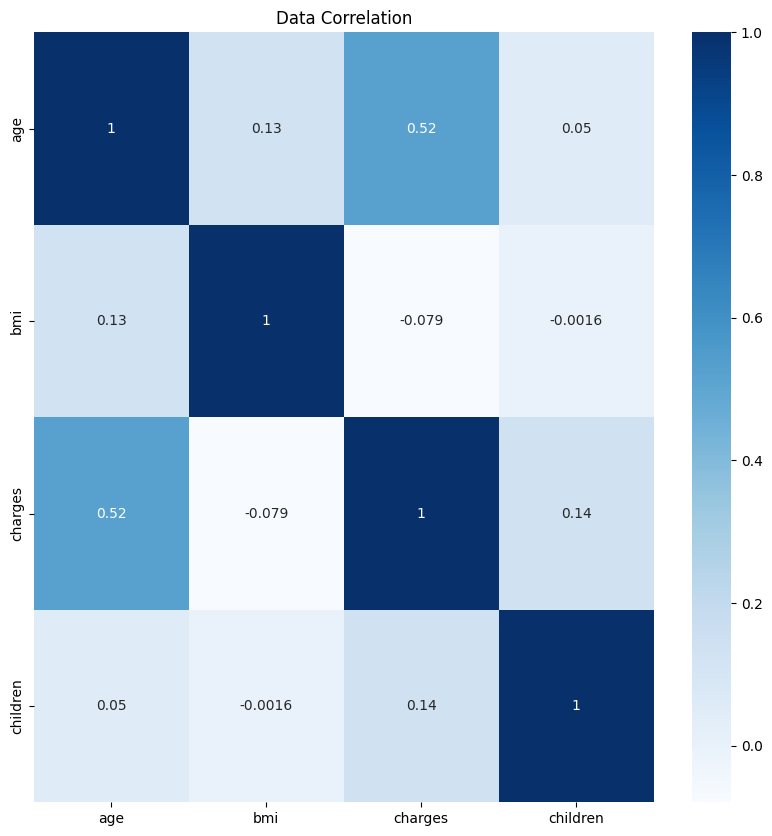

In [27]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_train[data_train.columns.difference(ctgvar_col)].corr(), cmap='Blues', annot=True) 
plt.title('Data Correlation')
plt.show()

> It's noteworthy that the correlation between the numerical independent variables and dependent variable ranges vary. The correlation between "charges" and all independent variables ranges from (absolute) 0.079 to 0.52, which indicate a weak to moderate relationship [1].

> Among all available independent variables, the "bmi" has the weakest correlation with dependent variable in this dataset. This suggests that a person's body mass index (bmi) does not significantly affect its value in the context of insurance costs. This might be because a person's bmi could influence whether they can afford insurance, given that lifestyle and health are factors, which is applied to the current reality.

> However, since one of the requirements in this case is to use all independent variables in the dataset, then I decided to keep all available variables.

In [28]:
def generate_ANOVA(data, ctgvar_col, col_target):
  for col in ctgvar_col:
    unique_values = data[col].unique()
    lists = {}
    for val in unique_values:
      lists[val] = data[data[col] == val][col_target]
    fvalue, pvalue = stats.f_oneway(*lists.values())
    print('=======')
    print(f"Column: {col}")
    print(f"Fvalue: {fvalue}")
    print(f"Pvalue: {pvalue}")

In [29]:
generate_ANOVA(data_train, ctgvar_col, 'charges')

Column: sex
Fvalue: 0.7554928514781153
Pvalue: 0.38497496436824274
Column: smoker
Fvalue: 451.0625862850715
Pvalue: 1.9896940453685945e-81
Column: region
Fvalue: 3.7803793574082745
Pvalue: 0.010322175772368134


> The p-value obtained from the ANOVA test is used to determine whether the differences among the group means are statistically significant. A high p-value (typically above 0.05) indicates that the differences among the group means are not statistically significant [5]. As for the F-value, it is a measure of the overall variation of the model. The larger the F-value, the more likely greater variations between samples in the variables groups [6].

> In this case, the categorical variable "sex" has a relationship with "charges", resulting in an F-value of 0.755 and a p-value of 0.385. Given the high p-value, it suggests that there is no statistically significant difference in "charges" across different "sex".

> However, since one of the requirements in this case is to use all independent variables in the dataset, then I decided to keep "sex" despite its weak relationship with "charges". In real-world business scenarios, sex may significantly influence costs and salaries, especially in industries like insurance, a real case example, government regulations based on sex can lead to differential impacts on expenses. Therefore, even though it might not always have a direct impact on profits, state is still an essential part of business expenses. Hence, this approach adopts a comprehensive approach that mirrors the nature of business operations, providing a broader perspective to enhances understanding of the various factors that contribute to profitability.

> Next, checking multicollinearity using Variance Inflation Factor (VIF). For categorical variables, this can be done by creating dummy variables. However, when the number of created dummy variables equals the number of $k$ unique values, there is a possibility of a dummy variable trap. Dummy variable trap occurs when the number of dummy variables created is equal to the number of values the categorical value can take on which it leads to multicollinearity [7]. This can be avoided by creating $k-1$ dummy variables by dropping the most frequently appearing category.

> Next, checking multicollinearity using Variance Inflation Factor (VIF).

In [30]:
data_train = pd.get_dummies(data_train, columns=ctgvar_col, drop_first=True, dtype=int)

In [31]:
def generate_VIF(data):
  vif_data = pd.DataFrame({
    'feature' : data.columns,
    'VIF' : [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
  })
  print(vif_data)

In [32]:
generate_VIF(data_train)

            feature        VIF
0               age  16.282777
1               bmi  11.327052
2          children   1.842894
3           charges  10.850407
4          sex_male   1.967341
5        smoker_yes   2.443320
6  region_northwest   1.988605
7  region_southeast   2.315016
8  region_southwest   2.117500


> The obtained Variance Inflation Factor (VIF) for the independent variables in the dataset indicates a correlation that is potentially severe for some variables and not for others [2]. The variables with the highest VIF are "age" and "bmi" with score exceeds 10, which are significantly higher than the general rule of thumb threshold of 10 [3]. This suggests signs of serious multicollinearity requiring correction. Therefore, based on these results, it can be concluded that while each variable brings some unique information to the model, the level of multicollinearity for certain variables is high enough to potentially distort the model significantly.

> However, since one of the requirements in this case is to use all independent variables in the dataset, I decided to keep the rest despite its high VIF.

# Feature Transformation

In [33]:
scalar = StandardScaler()

In [34]:
data_train[numvar_col] = scalar.fit_transform(data_train[numvar_col])
data_train.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
1225,-0.363991,1.593273,-0.045899,4795.6568,0,0,0,1,0
209,0.139554,1.826281,-0.045899,6610.1097,1,0,0,0,0
1309,0.211489,0.334036,0.797140,6875.9610,1,0,0,0,1
1075,-0.435926,-0.097278,-0.045899,4562.8421,0,0,0,1,0
711,0.858904,-1.097065,0.797140,10107.2206,0,0,0,1,0


# Data Splitting

In [35]:
data_train, data_valid = split_dataset(data_train.drop(columns='charges'), data_train['charges'], 0.75, 1)

> Dividing the training data into training and validation sets using a 3:1 ratio.

# Model Building

In [36]:
class linear_regression:
  def __init__(self, w, b):
    self.w = w
    self.b = b

  def predict(self, x):
    return np.dot(x, self.w) + self.b

  def update_w(self, x, y, y_predict):
    return np.dot((y_predict - y), x) / len(y) * 2

  def update_b(self, y, y_predict):
    return sum(y_predict - y) / len(y) * 2

  def loss_function(self, y, y_predict):
    return np.sum((y - y_predict)**2) / len(y)

  def fit(self, x, y, learn_rate, epochs):
    loss = []
    for i in range(epochs):
      y_predict = self.predict(x)
      self.b = self.b - learn_rate * self.update_b(y, y_predict)
      self.w = self.w - learn_rate * self.update_w(x, y, y_predict)
      loss.append(self.loss_function(y, y_predict))
    return loss

In [37]:
def loss_visualization(loss, learn_rate, epochs):
  for i in range(len(loss)):
    plt.plot(np.arange(1, epochs), loss[i][1:], label=learn_rate[i])
  plt.title('Number of Epochs vs Loss')
  plt.xlabel('Number of Epochs', size=10)
  plt.ylabel('Loss', size=10)
  plt.legend()

> Besides weights and bias, we also need to optimize the learning rate. In this case, we will try using several learning rates to see the most effective learning rates with this dataset.

In [38]:
losses, w, b = [], [], []
learn_rates = [0.005, 0.01, 0.05, 0.1, 0.3]
epochs = 5000

for i in range(len(learn_rates)):
  model = linear_regression(np.zeros(data_train.drop(columns='charges').shape[1]), 0)
  losses.append(model.fit(data_train.drop(columns='charges'), data_train['charges'], learn_rates[i], epochs))
  w.append(model.w)
  b.append(model.b)

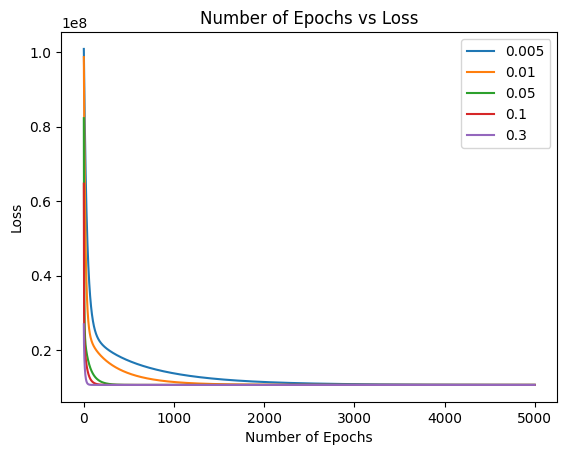

In [39]:
loss_visualization(losses, learn_rates, epochs)

In [40]:
loss = []
for i in range(len(learn_rates)):
  loss.append([learn_rates[i], losses[i][epochs - 2]])
loss = sorted(loss, key=lambda x:x[1])
print(f"Learning rate ({loss[0][0]}) produces smallest loss: {loss[0][1]}")

Learning rate (0.1) produces smallest loss: 10610132.682445446


> Based on the results above, it can be concluded that learning rate 0.1 is the most effective in minimizing the loss on this dataset (closest to 0). However, it is important to note that the loss score remains relatively high.

In [41]:
print(f"Weights: {w[3]}")
print(f"Bias: {b[3]}")

Weights: [ 3103.05324183   179.01514563   613.66855832  -611.11877407
 12630.6767572   -813.21448625 -1173.85758472 -1199.2248016 ]
Bias: 8613.123815361092


> This weights and bias will be used on the final model in the next part.

## Train The Final Model

In [42]:
loss = []
learn_rate = [0.1]
model_final = linear_regression(w[3], b[3])
loss.append(model.fit(data_train.drop(columns='charges'), data_train['charges'], learn_rates[0], epochs))

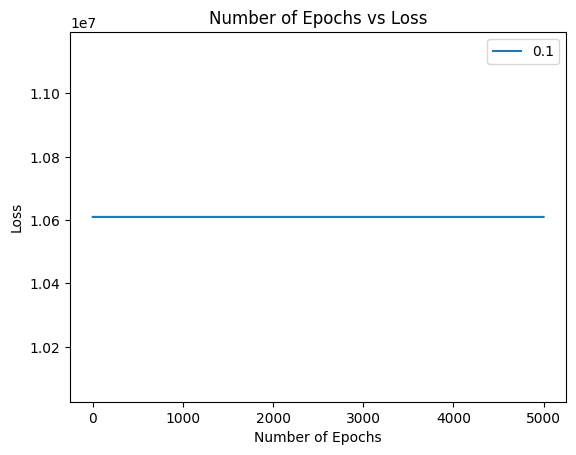

In [43]:
loss_visualization(loss, learn_rate, epochs)

> The loss score remains constant during the training of the final model, indicating that the model parameters have likely converged and further training does not significantly reduce the loss.

In [44]:
print(f"Weights: {model_final.w}")
print(f"Bias: {model_final.b}")

Weights: [ 3103.05324183   179.01514563   613.66855832  -611.11877407
 12630.6767572   -813.21448625 -1173.85758472 -1199.2248016 ]
Bias: 8613.123815361092


# Model Evaluation

In [45]:
data_valid['charges predict'] = model_final.predict(data_valid.drop(columns='charges'))
data_valid.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,charges,charges predict
1161,-0.292056,1.975010,0.797140,1,0,0,1,0,5124.18870,6764.617452
868,1.650190,-1.078061,-0.888937,1,0,0,0,0,13129.60345,12384.130473
681,-1.371082,-1.632489,-0.888937,1,0,0,0,1,1242.26000,1710.486560
672,-0.148186,-0.079100,-0.888937,1,0,0,1,0,4399.73100,5808.644879
600,-1.443017,1.484205,-0.888937,0,0,0,1,0,1633.04440,2681.689608


In [46]:
print(f"Loss: {model_final.loss_function(data_valid['charges'], data_valid['charges predict']):.3f}")

Loss: 5771273.193


In [47]:
print(f"RMSE Score: {np.sqrt(model_final.loss_function(data_valid['charges'], data_valid['charges predict'])):.3f}")

RMSE Score: 2402.347


In [48]:
print(f"MAE Score: {mean_absolute_error(data_valid['charges'], data_valid['charges predict']):.3f}")

MAE Score: 1435.221


In [49]:
print(f"R2 Score: {r2_score(data_valid['charges'], data_valid['charges predict']):.3f}")

R2 Score: 0.795


> This model achieved a Mean Squared Error (MSE) score of 5771273.193. This high MSE indicates that there is a significant difference between the predicted and actual values. The model also achieved a Root Mean Squared Error (RMSE) score of 2402.347 and a Mean Absolute Error (MAE) score of 1435.221, both of which further indicate the magnitude of prediction errors. However, this model also achieved an R-squared (R²) score of 0.795. This suggests that approximately 79.5% of the variance in the dependent variable can be explained by the model's independent variables [4].

> Hence, it can be concluded that this final model provides a reasonable baseline prediction. However, the high error scores indicate that the predictions may not closely match the actual values.

## Predict using Test Dataset

In [50]:
data_test = pd.get_dummies(data_test, columns=ctgvar_col, drop_first=True, dtype=int)

In [51]:
data_test[numvar_col] = scalar.fit_transform(data_test[numvar_col])
data_test.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
831,-0.325172,-0.759960,-0.934561,5266.36560,0,0,1,0,0
1287,-0.325172,-0.750543,-0.159136,5472.44900,0,0,0,0,1
1259,0.835808,-1.177467,-0.934561,10197.77220,0,0,0,0,0
827,-0.325172,-0.417009,-0.159136,20773.62775,1,1,0,0,0
933,0.327879,0.724856,-0.934561,7348.14200,0,0,0,0,1


In [52]:
data_test['charges predict'] = model_final.predict(data_test.drop(columns='charges'))
data_test.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,charges predict
831,-0.325172,-0.759960,-0.934561,5266.36560,0,0,1,0,0,6081.328885
1287,-0.325172,-0.750543,-0.159136,5472.44900,0,0,0,0,1,6172.858486
1259,0.835808,-1.177467,-0.934561,10197.77220,0,0,0,0,0,10422.385163
827,-0.325172,-0.417009,-0.159136,20773.62775,1,1,0,0,0,19451.348964
933,0.327879,0.724856,-0.934561,7348.14200,0,0,0,0,1,7987.575419


In [53]:
print(f"Loss: {model_final.loss_function(data_test['charges'], data_test['charges predict']):.3f}")

Loss: 74861798.688


In [54]:
print(f"RMSE Score: {np.sqrt(model_final.loss_function(data_test['charges'], data_test['charges predict'])):.3f}")

RMSE Score: 8652.271


In [55]:
print(f"MAE Score: {mean_absolute_error(data_test['charges'], data_test['charges predict']):.3f}")

MAE Score: 4388.971


In [56]:
print(f"R2 Score: {r2_score(data_test['charges'], data_test['charges predict']):.3f}")

R2 Score: 0.461


> This model achieved a Mean Squared Error (MSE) score of 74861798.688. This high MSE indicates that there is a significant difference between the predicted and actual values. The model also achieved a Root Mean Squared Error (RMSE) score of 8652.271 and a Mean Absolute Error (MAE) score of 4388.971, both of which further indicate the magnitude of prediction errors. However, this model also achieved an R-squared (R²) score of 0.461. This suggests that approximately 46.1% of the variance in the dependent variable can be explained by the model's independent variables [4].

> Hence, it can be concluded that this final model provides a reasonable baseline prediction. However, the high MSE score indicates that the predictions may not closely match the actual values.

> In conclusion, the model has shown a high level of performance in both the validation and testing phases in terms of R-squared (R²). Despite the high MSE scores, the strong R² scores indicate that the model has a good fit to the data. Therefore, while the model's predictions may not closely align with the actual values due to the high MSE, its high R² scores indicate that it can still be a useful tool for making further predictions.

# Visualize

In [57]:
data = pd.concat([data_valid, data_test])

In [58]:
def visualize_final(data, title, xlabel, ylabel):
  xl = np.array([min(min(data[xlabel]), min(data[ylabel])), max(max(data[xlabel]), max(data[ylabel]))])
  plt.plot(xl, xl, color = 'black', linestyle = 'dashed')
  plt.scatter(data[xlabel], data[ylabel])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

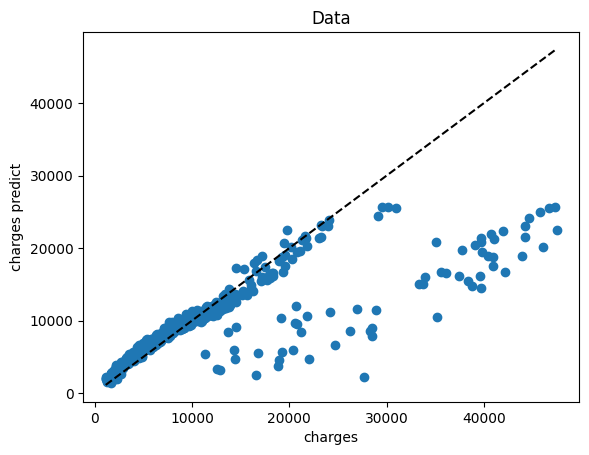

In [59]:
visualize_final(data, 'Data', 'charges', 'charges predict')